# Predicting checkin from restaurant neighborhood and categories
In this notebook we try to predict the number of checkins a restaurant had based on the neighborhood it is in and the categories (cusines) it has.

## Loading the dataset
Since we only care about the restaurants, we can filter the `yelp_academic_dataset_business.json` to exclude businesses without one of the following categories:
- Restaurant
- Food
- Bar

In [1]:
import itertools as it
import json
import pandas as pd
import pyspark as spark
import pyspark.sql.functions as F

In [2]:
restaurant_categories = {'restaurants', 'food', 'bars'}
restaurants = sc.textFile('../data/raw/yelp_academic_dataset_business.json') \
    .map(lambda row: json.loads(row)) \
    .filter(lambda business: business['categories'] is not None and business.get('is_open', 0)) \
    .filter(lambda business: restaurant_categories & {x.strip().lower() for x in business['categories'].split(',')})

We can load the checkins from `yelp_academic_dataset_checkin.json`.

In [3]:
checkin = sc.textFile('../data/raw/yelp_academic_dataset_checkin.json') \
    .map(lambda row: json.loads(row)) \
    .map(lambda checkin: (checkin['business_id'], sum(checkin['time'].values())))

The number of restaurants and checkins are:

In [4]:
restaurants.count(), checkin.count()

(55743, 157075)

We can add the checkin value of a restaurant into the restaurant object.

In [5]:
def get_restaurants_with_checkins(restaurants, checkin):
    keyed_restaurants = restaurants.keyBy(lambda r: r['business_id'])
    def update_restaurant(restaurant, checkin):
        restaurant['checkin'] = checkin
        return restaurant
    return checkin.join(keyed_restaurants).map(lambda tup: update_restaurant(tup[1][1], tup[1][0]))

restaurants = get_restaurants_with_checkins(restaurants, checkin).cache()

Number of restaurants with checkin data:

In [6]:
restaurants.count()

54087

## Checking Predictions
We now try to model the checkins of a restaurant as a naive bayes classifier on the categories and neighborhoods. For now, we will discard all restaurants without any neighborhoods.

We will also confine ourselfes to one city at a time. First let's look at Toronto.

In [7]:
toronto = restaurants.filter(lambda r: r['city'] == 'Toronto' and r['neighborhood']).cache()
toronto.count()

5495

Before we try to predict the checkin, we may need to normalize it on a per city basis. Let's have a look at the distribution of the checkin data.

In [8]:
import numpy as np
import math
from matplotlib import pyplot as plt

def plot_checkin_distr(restaurants, num_bins):
    checkins = np.array(restaurants.map(lambda r: r['checkin']).collect())
    c_min, c_max, c_mean = min(checkins), max(checkins), np.mean(checkins)
    bins = np.linspace(math.ceil(c_min), math.floor(c_max), num_bins)
    plt.xlim([c_min - c_mean, c_max + c_mean / 2])
    plt.hist(checkins, bins=bins, alpha=0.5)
    plt.xlabel('Checkins')
    plt.ylabel('Count')
    plt.show()

plot_checkin_distr(toronto, 25)

<Figure size 640x480 with 1 Axes>

The distribution doesn't look like a normal distribution, but looks exponential. Let's try to fit an exponential distribution to our data. To compare against a fitted distribution, we also need to normalize that counts to between 0, and 1.

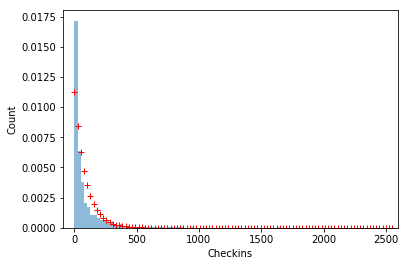

In [9]:
from scipy.stats import expon

def fit_checkin_distr(restaurants, num_bins):
    checkins = np.array(restaurants.map(lambda r: r['checkin']).collect())
    c_min, c_max, c_mean = min(checkins), max(checkins), np.mean(checkins)
    bins = np.linspace(math.ceil(c_min), math.floor(c_max), num_bins)
    
    # Fit to exponential distribion
    loc, scale = expon.fit(checkins)
    fitted_pdf = expon.pdf(bins, loc=loc, scale=scale)
    
    # Plot the distributions
    plt.xlim([c_min - c_mean, c_max + c_mean / 2])
    plt.hist(checkins, bins=bins, alpha=0.5, density=True)
    plt.plot(bins, fitted_pdf, 'r+')
    plt.xlabel('Checkins')
    plt.ylabel('Count')
    plt.show()
    return scale

scale = fit_checkin_distr(toronto, 100)

To create equal sized bins for a distribution, we can use the quantile function for the distribution. The below function implements the quantile function for an exponential distribution (see [wikipedia](https://en.wikipedia.org/wiki/Exponential_distribution#Quantiles)).

In [10]:
def get_checkin_bins(num_bins, scale):
    # scale is equal to 1/lambda according to http://reliawiki.org/index.php/The_Exponential_Distribution
    ret = []
    for i in range(num_bins):
        p = i / num_bins
        ret.append(-math.log(1 - p) * scale)
    return np.array(ret)

get_checkin_bins(10, scale)

array([ -0.        ,   9.36889864,  19.84243625,  31.71635387,
        45.42378579,  61.63623668,  81.47867293, 107.06002246,
       143.1149096 , 204.75114628])

To create the classifier, we also need to choose the categories we intend to use.

In [11]:
all_categories = toronto \
    .flatMap(lambda r: ((c.strip().lower(), 1) for c in r['categories'].split(','))) \
    .countByKey()

In [26]:
sorted(list(all_categories.items()), key=lambda x: x[1], reverse=True)

[('restaurants', 4002),
 ('food', 2188),
 ('nightlife', 872),
 ('bars', 858),
 ('coffee & tea', 762),
 ('specialty food', 445),
 ('sandwiches', 392),
 ('breakfast & brunch', 367),
 ('chinese', 348),
 ('cafes', 343),
 ('canadian (new)', 336),
 ('bakeries', 317),
 ('fast food', 298),
 ('pizza', 292),
 ('desserts', 281),
 ('italian', 276),
 ('japanese', 271),
 ('burgers', 242),
 ('pubs', 241),
 ('grocery', 213),
 ('american (traditional)', 207),
 ('sushi bars', 194),
 ('event planning & services', 173),
 ('indian', 157),
 ('juice bars & smoothies', 153),
 ('asian fusion', 151),
 ('korean', 149),
 ('mexican', 148),
 ('middle eastern', 144),
 ('thai', 142),
 ('mediterranean', 142),
 ('salad', 140),
 ('chicken wings', 138),
 ('ice cream & frozen yogurt', 138),
 ('seafood', 134),
 ('beer', 115),
 ('wine & spirits', 115),
 ('vegetarian', 112),
 ('caterers', 108),
 ('arts & entertainment', 108),
 ('lounges', 104),
 ('cocktail bars', 103),
 ('comfort food', 102),
 ('vegan', 101),
 ('greek', 99),

We discard the ones with less than 10 counts and choose the following 91 categories manually:

In [12]:
chosen_categories = {'coffee & tea', 'specialty food', 'sandwiches', 'breakfast & brunch', 'chinese', 'cafes',
                     'canadian (new)', 'bakeries', 'fast food', 'pizza', 'desserts', 'italian', 'japanese', 'burgers', 'pubs',
                     'american (traditional)', 'sushi bars', 'indian', 'juice bars & smoothies', 'asian fusion', 'korean',
                     'mexican', 'middle eastern', 'thai', 'mediterranean', 'salad', 'chicken wings',
                     'ice cream & frozen yogurt', 'seafood', 'beer', 'wine & spirits', 'vegetarian', 'comfort food', 'vegan',
                     'greek', 'barbeque', 'vietnamese', 'diners', 'caribbean', 'french', 'american (new)', 'halal',
                     'ethnic food', 'gluten-free', 'delis', 'tea rooms', 'gastropubs', 'tapas/small plates', 'soup',
                     'steakhouses', 'bubble tea', 'dim sum', 'noodles', 'donuts', 'chicken shop', 'portuguese',
                     'chocolatiers & shops', 'ramen', 'tapas bars', 'latin american', 'bagels', 'pakistani', 'fish & chips',
                     'taiwanese', 'modern european', 'tex-mex', 'british', 'creperies', 'southern', 'filipino', 'african',
                     'hot dogs', 'irish', 'poke', 'ethiopian', 'afghan', 'turkish', 'falafel', 'hot pot', 'spanish',
                     'local flavor', 'himalayan/nepalese', 'hawaiian', 'lebanese', 'persian/iranian', 'polish', 'waffles',
                     'soul food', 'malaysian', 'sri lankan', 'live/raw food'}

In [13]:
len(chosen_categories)

91

We can now get to creating the classifer.

In [14]:
from sklearn.naive_bayes import BernoulliNB
from types import SimpleNamespace

class CheckinPredictorDataBuilder(object):
    def __init__(self, restaurants_rdd, chosen_categories):
        self.chosen_categories = chosen_categories
        self.restaurants = restaurants_rdd.map(lambda r: SimpleNamespace(
            neighborhood=r['neighborhood'],
            categories=({c.strip().lower() for c in r['categories'].split(',')} & chosen_categories),
            checkins=r['checkin'],
            business_id=r['business_id']
        )).collect()
        self.neighborhood_encoding = self._categorical_to_ind({r.neighborhood for r in self.restaurants})
        self.categories_encoding = self._categorical_to_ind(chosen_categories)
        self.checkin_scale = self._get_checkin_scale([r.checkins for r in self.restaurants])
    
    def _categorical_to_ind(self, categorical_data_set):
        return {data: i for i, data in enumerate(categorical_data_set)}

    def _get_checkin_scale(self, checkin_data):
        loc, scale = expon.fit(checkin_data)
        return scale
    
    def get_encoded_data(self, num_bins):
        feature_vecs_X, feature_vec_Y = [], []
        for r in self.restaurants:
            n_feature_vec = np.zeros(len(self.neighborhood_encoding))
            n_feature_vec[self.neighborhood_encoding[r.neighborhood]] = 1
            c_feature_vec = np.zeros(len(self.categories_encoding))
            for c in r.categories:
                c_feature_vec[self.categories_encoding[c]] = 1
            feature_vecs_X.append(np.hstack([n_feature_vec, c_feature_vec]))
            feature_vec_Y.append(r.checkins)
        checkin_bins = get_checkin_bins(num_bins, self.checkin_scale)
        return np.vstack(feature_vecs_X), np.digitize(feature_vec_Y, checkin_bins)
    
    def fit(self, num_bins):
        encoded_X, encoded_Y = self._get_encoded_data(num_bins)
        model = BernoulliNB()
        return model.fit(encoded_X, encoded_Y)
        

In [15]:
data_builder = CheckinPredictorDataBuilder(toronto, chosen_categories)

In [16]:
X, Y = data_builder.get_encoded_data(5)

In [17]:
model = BernoulliNB().fit(X, Y)

In [18]:
predictions = model.predict(X)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix

In [20]:
accuracy_score(Y, predictions)

0.43239308462238396

In [21]:
precision_score(Y, predictions, average=None)

array([0.46687341, 0.34541578, 0.30645161, 0.31818182, 0.38831886])

In [22]:
f1_score(Y, predictions, average=None)

array([0.59058488, 0.20742638, 0.08597285, 0.08284024, 0.43539823])

In [23]:
recall_score(Y, predictions, average=None)

array([0.80349345, 0.14821592, 0.05      , 0.04761905, 0.49546828])

In [24]:
cp = confusion_matrix(Y, predictions)
cp / np.sum(cp, axis=0)

array([[0.46687341, 0.2750533 , 0.24193548, 0.17045455, 0.18232044],
       [0.2015788 , 0.34541578, 0.16935484, 0.17045455, 0.14206788],
       [0.1291232 , 0.15565032, 0.30645161, 0.14772727, 0.14048934],
       [0.08655202, 0.10021322, 0.16129032, 0.31818182, 0.14680347],
       [0.11587257, 0.12366738, 0.12096774, 0.19318182, 0.38831886]])

In [295]:
model.predict_proba(X)

array([[0.35831093, 0.26143056, 0.08067146, 0.091132  , 0.20845505],
       [0.60153897, 0.23412888, 0.07231885, 0.026607  , 0.0654063 ],
       [0.5771909 , 0.16185134, 0.1030889 , 0.05901862, 0.09885024],
       ...,
       [0.00305663, 0.01076454, 0.06568855, 0.02513615, 0.89535413],
       [0.41092481, 0.34411737, 0.07664654, 0.11907185, 0.04923944],
       [0.38480009, 0.32466655, 0.11005265, 0.06110602, 0.11937469]])

In [263]:
X.shape

(5495, 163)

In [239]:
phoenix = restaurants.filter(lambda r: r['city'] == 'Phoenix')